Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, r2_score
from sklearn.datasets import load_digits
from sklearn import metrics 
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [3]:
from scipy.cluster import hierarchy

In [4]:
import seaborn as sns
import time

In [5]:
digits = load_digits()
X = digits.data
y = digits.target
print(f'X shape is: {X.shape}')
print(f'y shape is: {y.shape}')

X shape is: (1797, 64)
y shape is: (1797,)


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

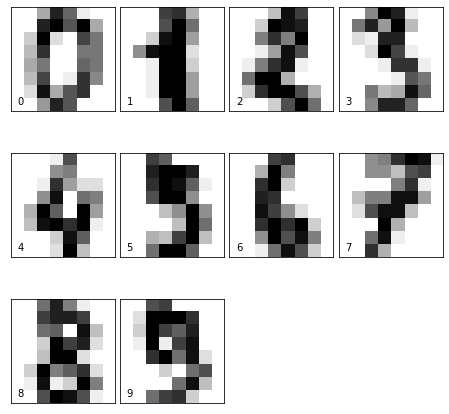

In [6]:
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [7]:
X = digits.data
y = digits.target
print(f'X shape is: {X.shape}')
print(f'y shape is: {y.shape}')

X shape is: (1797, 64)
y shape is: (1797,)


### Иерархическая кластеризация AgglomerativeClustering

In [8]:
clustering = AgglomerativeClustering(n_clusters=10).fit_predict(X)
print(f'Length is {clustering.size} numbers and consist of {len(set(clustering))} clusters.')

Length is 1797 numbers and consist of 10 clusters.


### Mетод  𝐾-means 

In [9]:
kmeans = KMeans(n_clusters=10, n_init=100, random_state=42).fit_predict(X)
print(f'Length is {len(kmeans)} numbers and consist of {len(set(kmeans))} clusters.')

Length is 1797 numbers and consist of 10 clusters.


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

### Иерархическая кластеризация AgglomerativeClustering

In [10]:
clusters_AC = np.empty((10,64))
for i in range(0,10):
    clusters_AC[i] = X[clustering==i].mean(axis=0)

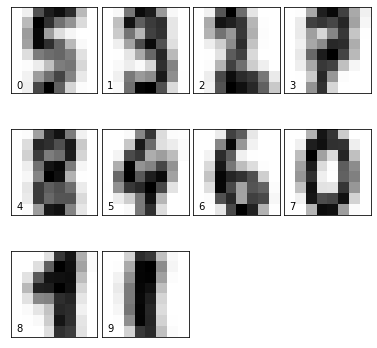

In [11]:
fig = plt.figure(figsize=(5, 5))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(clusters_AC[i].reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Четкие - 7/10
Узнаваемые - 1/10
Слились - 1/10
Нечитаемые - 1/10

### Mетод 𝐾-means

In [12]:
clusters_KMeans = np.empty((10,64))
for i in range(0,10):
    clusters_KMeans[i] = X[kmeans==i].mean(axis=0)
    

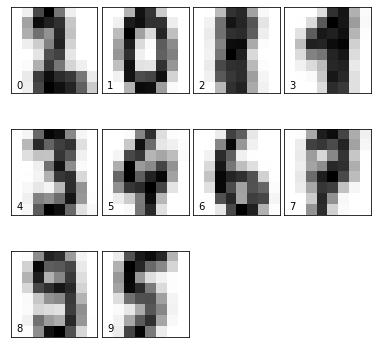

In [13]:
fig = plt.figure(figsize=(5, 5))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(clusters_KMeans[i].reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Четкие - 7/10
Узнаваемые - 1/10
Слились - 2/10
Нечитаемые - 0/10

####  Похоже, KMeans даёт более чёткие очертания цифр - отсутствуют совсем нечитаемые, в среднем качество изображений выше, чем у AgglomerativeClustering.

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [14]:
sc_K= []
sc_AC = []

for i in range(2,21):
    kmean = KMeans(n_clusters=i, random_state=42).fit(X)
    unScaled_labels = kmean.labels_   
    sc_K.append(metrics.silhouette_score(X, unScaled_labels))
    
    clustering = AgglomerativeClustering(n_clusters=i).fit_predict(X)
    #unScaled_labels = clustering.labels_
    sc_AC.append(metrics.silhouette_score(X, clustering))

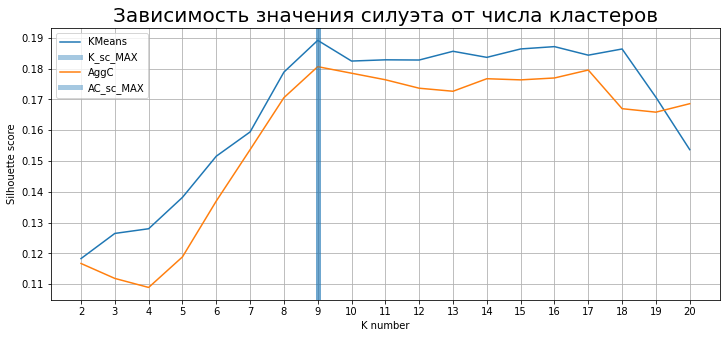

In [15]:
plt.figure(figsize=(12,5))

plt.plot(range(2, 21),sc_K, label='KMeans')
plt.axvline(sc_K.index(max(sc_K))+2, color='C10', lw=5, alpha=0.4, label='K_sc_MAX')

plt.plot(range(2, 21),sc_AC, label='AggC')
plt.axvline(sc_AC.index(max(sc_AC))+2, color='C10', lw=5, alpha=0.4, label='AC_sc_MAX') 

plt.xlabel('K number')
plt.xticks(range(2,21))
plt.ylabel('Silhouette score')
plt.legend(loc='upper left')

plt.title('Зависимость значения силуэта от числа кластеров', fontsize=20)
plt.grid(True)
plt.show()

### При К=9 достигается максимум силуэта

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [16]:
X = digits.data
y = digits.target 

In [17]:
v_K = []
v_AC = []

for i in range(2,21):
    kmean = KMeans(n_clusters=i, random_state=42).fit(X)
    unScaled_labels = kmean.labels_   
    v_K.append(metrics.v_measure_score(unScaled_labels, y))
    
    clustering = AgglomerativeClustering(n_clusters=i).fit_predict(X)
    v_AC.append(metrics.v_measure_score(clustering, y))

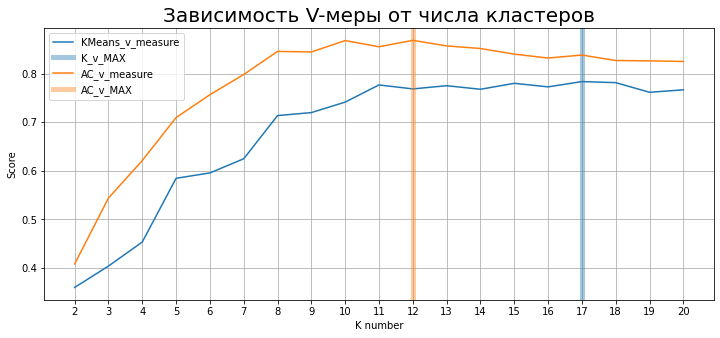

In [18]:
plt.figure(figsize=(12,5))

plt.plot(range(2, 21),v_K, label='KMeans_v_measure' )
plt.axvline(v_K.index(max(v_K))+2, color='C10', lw=5, alpha=0.4, label='K_v_MAX')

plt.plot(range(2, 21),v_AC, label='AC_v_measure' )
plt.axvline(v_AC.index(max(v_AC))+2, color='C1', lw=5, alpha=0.4, label='AC_v_MAX')
            
plt.xlabel('K number')
plt.xticks(range(2,21))
plt.ylabel('Score')
plt.legend(loc='best')

plt.title('Зависимость V-меры от числа кластеров', fontsize=20)
plt.grid(True)
plt.show()

### Максимальное значение V-меры достигается при разных количествах кластеров: для KMeans это 17, для AgglomerativeClustering - 12 кластеров.

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [19]:
X = digits.data
y = digits.target 

In [20]:
numbers = [2, 5, 10, 20]
for number in numbers:
    svd = TruncatedSVD(n_components=number, algorithm='randomized', 
                         n_iter=5, random_state=42).fit_transform(X)

    #AgglomerativeClustering
    clustering_svd = AgglomerativeClustering(n_clusters=10).fit_predict(svd)
    
    print(f'{number} features.')
    print(' ')
    
    print(f'V score AC: {metrics.v_measure_score(clustering_svd, y)}')
    print(f'Silhouette score AC: {metrics.silhouette_score(svd, clustering_svd)}')

    print(' ')

    #KMeans clustering
    kmeans_svd = KMeans(n_clusters=10, n_init=100, random_state=42).fit(svd)
    labels_svd = kmeans_svd.labels_
    
    print(f'V score Kmeans: {metrics.v_measure_score(labels_svd, y)}')
    print(f'Silhouette score Kmeans: {metrics.silhouette_score(svd, labels_svd)}')
    print('_________________________________________')

2 features.
 
V score AC: 0.33371899039489245
Silhouette score AC: 0.2808169776682731
 
V score Kmeans: 0.3463959564567859
Silhouette score Kmeans: 0.3491901087600824
_________________________________________
5 features.
 
V score AC: 0.6756036446423491
Silhouette score AC: 0.2727412452125096
 
V score Kmeans: 0.6353024562476132
Silhouette score Kmeans: 0.31252999347927296
_________________________________________
10 features.
 
V score AC: 0.8259753348813226
Silhouette score AC: 0.2507120685019135
 
V score Kmeans: 0.7203550603165754
Silhouette score Kmeans: 0.2631900673175692
_________________________________________
20 features.
 
V score AC: 0.8143882689038883
Silhouette score AC: 0.19713437638104186
 
V score Kmeans: 0.7425377623810182
Silhouette score Kmeans: 0.21252183906420935
_________________________________________


#### AC
Без снижения размерности silhouette max = 0.18, V-score max = 0.86.

После снижения размерности silhouette max = 0.28 при 2 признаках, V-score max = 0.82 при 10 признаках. 

#### KMeans
Без снижения размерности silhouette max = 0.19, V-score max = 0.79.

После снижения размерности silhouette max = 0.35 при 2 признаках, V-score max = 0.74 при 20 признаках. 


#### Таким образом, для обеих моделей снижение размерности до 2х значительно увеличило значение силуэта, но негативно отразилось на V-мере.



Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

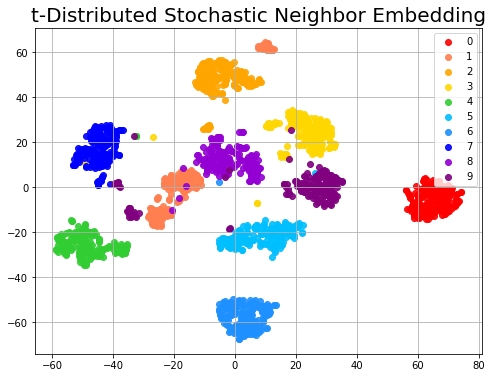

In [21]:
X = digits.data
y = digits.target
 
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)
digits_ids = range(len(digits.target_names))
 
plt.figure(figsize=(8, 6))
colors = 'red', 'coral', 'orange', 'gold', 'limegreen', 'deepskyblue', 'dodgerblue', 'blue', 'darkviolet', 'purple'
for i, c, label in zip(digits_ids, colors, digits.target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label, alpha=0.9)
    
plt.legend(loc='upper right')
plt.title('t-Distributed Stochastic Neighbor Embedding', fontsize=20)
plt.grid(True)
plt.show()

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [22]:
#AgglomerativeClustering
clustering_X_2d = AgglomerativeClustering(n_clusters=10).fit_predict(X_2d)

print(f'V score AC: {metrics.v_measure_score(clustering_X_2d, y)}')
print(f'Silhouette score AC: {metrics.silhouette_score(X_2d, clustering_X_2d)}')

print(' ')

#KMeans clustering
kmeans_X_2d = KMeans(n_clusters=10, n_init=100, random_state=42).fit(X_2d)
labels_X_2d = kmeans_X_2d.labels_

print(f'V score Kmeans: {metrics.v_measure_score(labels_X_2d, y)}')
print(f'Silhouette score Kmeans: {metrics.silhouette_score(X_2d, labels_X_2d)}')

V score AC: 0.9111471953871231
Silhouette score AC: 0.6421834230422974
 
V score Kmeans: 0.9137798316714038
Silhouette score Kmeans: 0.6432376503944397


#### С  tSNE-преобразованными данными удалось достигнуть максимальных значений силуэта и V-меры для обеих моделей.

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

#### Раз разбиение по t-SNE дает такие высокие значения силуэта и V-меры, попробуем визуализировать центры кластеров, используя его.

## AC

In [23]:
clusters_AC = np.empty((10,64))
for i in range(0,10):
    clusters_AC[i] = X[clustering_X_2d==i].mean(axis=0)

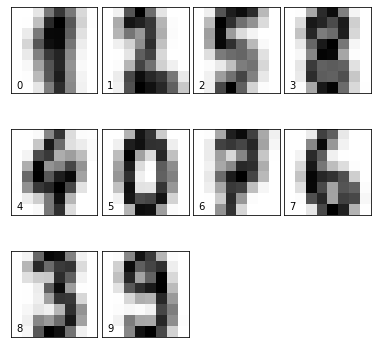

In [24]:
fig = plt.figure(figsize=(5, 5))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(clusters_AC[i].reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(y[i]))

## KMeans

In [25]:
clusters_KMeans = np.empty((10,64))
for i in range(0,10):
    clusters_KMeans[i] = X[labels_X_2d==i].mean(axis=0)
    

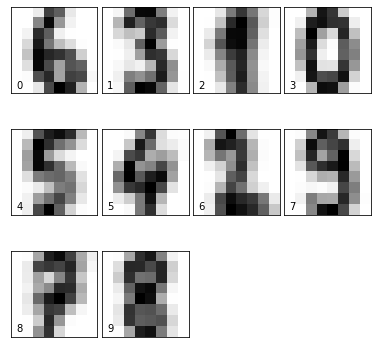

In [26]:
fig = plt.figure(figsize=(5, 5))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(clusters_KMeans[i].reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(y[i]))

#### К сожалению, выдающихся улучшений добиться не удалось, но хотя бы появилась цифра 8 и в целом каждая цифра читаема (7 хуже всех).

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

Применение алгоритмов кластеризации с последующей оценкой их результатов является сложной процедурой анализа данных.
Мы рассмотрели два алгоритма кластеризации: k-средние и агломеративную кластеризацию. 

Каждый из алгоритмов имеет свои преимущества. Оба метода могут быть использованы на больших наборах данных. Алгоритм kсредних позволяет описывать кластеры с помощью их средних значений. Однако даже если известно «правильное» количество кластеров для конкретного набора данных,  алгоритм k-средних не всегда может корректно выделить их. Алгоритм чувствителен к выбросам, которые могут искажать среднее, ему необходимо задавать количество кластеров, как видно из визуализации, его трудно применять на данных, где имеются пересекающиеся кластеры - цифра 7 очевидно сливается с 9.

Агломеративная кластеризация позволяет построить исчерпывающую иерархию возможных разбиений данных, которую можно  исследовать с помощью дендрограмм. Алгоритм не задает рандомные центроиды, а действует снизу вверх - каждая точка изначально является кластером, который далее объединяется с другим кластером-точкой, из-за этого алгоритм является вычислительно дорогостоящим. 

В целом более высокие показатели оценки качества модели отражают изменение предикта - например, после t-SNE значения силуэта и V-меры выросли, что отражает действительное повышение четкости предсказанных цифр. Так что можно сказать, что сниженная размерность признакового пространства улучшает качество кластеризации.


**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](https://stackoverflow.com/a/60450028). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [27]:
from sklearn.datasets import fetch_openml

In [28]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape, y.shape)

(70000, 784) (70000,)


In [29]:
# Сократим число образцов
N=35000
Xx = X[0:N]
yy = y[0:N]
print(Xx.shape, yy.shape)

(35000, 784) (35000,)


In [30]:
time_start = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(Xx)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 241.59835696220398 seconds


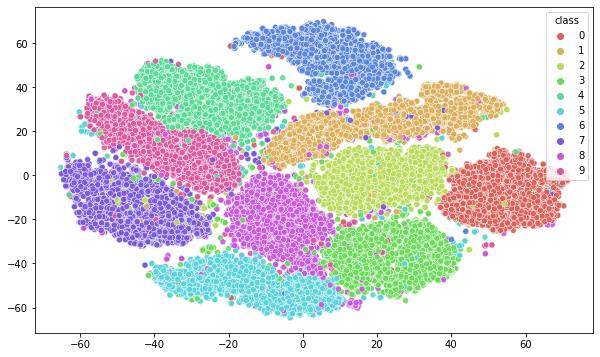

In [31]:
tsne_2d_one = X_2d[:,0]
tsne_2d_two = X_2d[:,1]
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=tsne_2d_one, y=tsne_2d_two,
    hue=yy,
    palette=sns.color_palette("hls", 10),
    data=Xx,
    legend="full",
    alpha=0.9
);

In [32]:
clustering_X_2d = AgglomerativeClustering(n_clusters=10).fit_predict(X_2d)

print(f'V score AC: {metrics.v_measure_score(clustering_X_2d, yy)}')
print(f'Silhouette score AC: {metrics.silhouette_score(X_2d, clustering_X_2d)}')

print(' ')

#KMeans clustering
kmeans_X_2d = KMeans(n_clusters=10, n_init=100, random_state=42).fit(X_2d)
labels_X_2d = kmeans_X_2d.labels_

print(f'V score Kmeans: {metrics.v_measure_score(labels_X_2d, yy)}')
print(f'Silhouette score Kmeans: {metrics.silhouette_score(X_2d, labels_X_2d)}')

V score AC: 0.8217169187735263
Silhouette score AC: 0.38934946060180664
 
V score Kmeans: 0.7602940717864537
Silhouette score Kmeans: 0.4246794283390045


#### Итоги

 При 40.000 образцов появляется Memory Error, так что я ограничусь 35.000. Кластеризация визульно кажется достаточно точной,  после уменьшения размерности при помощи t-SNE (n_components=2)  лучшее значение силуэта = 0.82 (AgglomerativeClustering(n_clusters=10)), а  𝑉 -меры = 0.42 (KMeans(n_clusters=10)).
